In [1]:
# %reset
import sys, os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_ENABLE_X64'] = 'True'
from jax import config
config.update("jax_enable_x64", True)
import pathlib
curr_path = pathlib.Path().absolute()
# Let's assume that we have a relative path to a file or directory (rel_path) within our current working directory.

abs_path_data = os.path.abspath(curr_path / "../../data/") 
abs_path_src = os.path.abspath(curr_path / "../../src/") 

sys.path.append((curr_path))
sys.path.append((abs_path_data))

sys.path.append(abs_path_src)
import dill
import sys, os
import pickle as pk

import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2
%reload_ext autocomplete





In [2]:
# cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
# cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.29, 'Ob0': 0.049, 'sigma8': 0.783, 'ns': 0.95, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 2.0
sim_params_dict['delta_rhogas'] = 7.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.1
sim_params_dict['log10_Mstar0_theta_co'] = 14.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 2.75
sim_params_dict['log10_Mstar0_theta_ej'] = 14.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.0

sim_params_dict['log10_Mc0'] = 14.83
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = 0.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 12, 32
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
# halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 3.0, 20
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 3.0, 24
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
# halo_params_dict['nz'] = len(halo_params_dict['z_array'])
# halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 12.0, 15.5, 20
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 11.0, 16.0, 32
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 9, 16

lmin = 1.0
lmax = 60000.0
fac = 1
dl_log_array = 0.23025851 / fac
# dl_log_array = 0.1
l_array_all = np.exp(np.arange(np.log(lmin), np.log(lmax), dl_log_array))
dl_array = l_array_all[1:] - l_array_all[:-1]
l_array_survey = (l_array_all[1:] + l_array_all[:-1]) / 2.
halo_params_dict['ell_array'] = jnp.array(l_array_survey)
halo_params_dict['nell'] = len(l_array_survey)
halo_params_dict['ellmin'] = l_array_survey[0]
halo_params_dict['ellmax'] = l_array_survey[-1]
# halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**14, 32
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.05
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
# halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['conc_model'] = 'Duffy08'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open(os.path.abspath(abs_path_data + '/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits'))
# df = fits.open('data/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
# nz_info_dict['nz4'] = np.maximum(df['nz_source'].data['BIN5'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = True

analysis_dict['fsky_yy'] = 0.1
analysis_dict['fsky_ky'] = 0.1
analysis_dict['fsky_kk'] = 0.1
analysis_dict['fac_ell_hres'] = fac

# df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits')
# df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits')
theta_data = df['xip'].data['ANG'][0:20]

# analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = True
analysis_dict['calc_nfw_only'] = False
analysis_dict['conc_dep_model'] = False


analysis_dict['get_cov'] = True
# analysis_dict['stats_for_cov'] = ['ky']
analysis_dict['stats_for_cov'] = ['ky', 'kk']
analysis_dict['analysis_coords'] = 'real'
# l_array_survey = np.logspace(np.log10(lmin), np.log10(lmax), int((lmax-lmin)/dl_log_array)+1)
analysis_dict['l_array_survey'] = jnp.array(l_array_survey)
analysis_dict['dl_array_survey'] = jnp.array(dl_array)
# analysis_dict['yy_total_ell_fname'] = '/Users/shivam/Downloads/ACT_Cls/Cls_ilc_SZ_deproj_cib_cibdBeta_1.7_10.7_yy_apod10arcmin_21Mar24.txt'
# analysis_dict['yy_total_ell_fname'] = '/Users/shivam/Downloads/ACT_Cls/Cls_ilc_SZ_yy_apod10arcmin_21Mar24.txt'
analysis_dict['yy_total_ell_fname'] = os.path.abspath(abs_path_data + '/DESxACT/ACT_Cls/Cls_ilc_SZ_yy_apod10arcmin_21Mar24.txt')
# analysis_dict['sigma_epsilon_SN_bins'] = [0.2724, 0.2724, 0.2724, 0.2724]
# analysis_dict['neff_arcmin2_SN_bins'] = [1.7971, 1.5521, 1.5967, 1.0979]

analysis_dict['sigma_epsilon_SN_bins'] = [0.243, 0.262, 0.259, 0.301]
analysis_dict['neff_arcmin2_SN_bins'] = [1.476, 1.479, 1.484, 1.461]

other_params_dict = {}
other_params_dict['A_IA'] = 0.0
other_params_dict['eta_IA'] = 0.0
other_params_dict['z0_IA'] = 0.62
other_params_dict['C1_rhocrit'] = 0.0134
other_params_dict['Delta_z_bias_array'] = np.zeros(nz_info_dict['nbins'])
other_params_dict['mult_shear_bias_array'] = np.zeros(nz_info_dict['nbins'])







In [3]:
import os
from get_power_spectra_NO_CONC_jit import get_power_BCMP_NO_CONC
from setup_power_spectra_NO_CONC_jit import setup_power_BCMP_NO_CONC
from get_corr_func_jit import get_corrfunc_BCMP
from get_cov_NO_CONC import get_cov_NO_CONC


In [4]:
setup_power_BCMP_obj = setup_power_BCMP_NO_CONC(sim_params_dict, halo_params_dict, analysis_dict)            




In [5]:
get_power_BCMP_obj = get_power_BCMP_NO_CONC(sim_params_dict, halo_params_dict, analysis_dict, other_params_dict, setup_power_BCMP_obj=setup_power_BCMP_obj)



In [7]:
get_corrfunc_BCMP_obj = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict, other_params_dict,
                                        setup_power_BCMP_obj=setup_power_BCMP_obj, get_power_BCMP_obj=get_power_BCMP_obj)




In [21]:
df_cs = fits.open(os.path.abspath(abs_path_data + '/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits'))
cov_xip_xim = df_cs['COVMAT'].data[:400,:400]
bin1_vals =  df_cs['xip'].data['BIN1'][::20]
bin2_vals =  df_cs['xip'].data['BIN2'][::20]
biny_vals = np.array([1,2,3,4])
nbins = 4
ntheta_bin = 20

# deproj_all = [ 'fid']
# deproj_all = [ 'None']
# deproj_all = ['cib_1p0','cib_1p2','cib_1p4','cib_1p6', 'cib_1p8', 'cib_2p0', 'cib_1p0_dBeta','cib_1p2_dBeta','cib_1p4_dBeta','cib_1p6_dBeta','cib_1p8_dBeta','cib_2p0_dBeta']
# deproj_all = ['cib_1p7_dBeta']
# deproj_all = ['None']
deproj_all = ['cib_1p4','cib_1p6', 'cib_1p7', 'cib_1p8', 'cib_2p0', 'cib_1p4_dBeta','cib_1p6_dBeta','cib_1p7_dBeta','cib_1p8_dBeta','cib_2p0_dBeta']

# deproj_all = ['fid']
# deproj_all = ['cib_1p7', 'cib_1p7_dBeta', 'cib_1p7_dT']
# DV.xi_result_dict['gty'].keys()
from astropy.io import fits

save_DV_dir = os.path.abspath(abs_path_data + '/DESxACT/DV/')
# deproj = deproj_all[0]
for deproj in deproj_all:
    xi_all = np.zeros(480)
    theta_all = np.zeros(480)
    bin1_all = np.zeros(480)
    bin2_all = np.zeros(480)    

    # for deproj in deproj_all:
    if deproj == 'None':
        true_y_file = 'ilc_SZ_yy'
    if deproj == 'cib_1p0':
        true_y_file = 'ilc_SZ_deproj_cib_1.0_10.7_yy'
    if deproj == 'cib_1p2':
        true_y_file = 'ilc_SZ_deproj_cib_1.2_10.7_yy'        
    if deproj == 'cib_1p4':
        true_y_file = 'ilc_SZ_deproj_cib_1.4_10.7_yy'        
    if deproj == 'cib_1p6':
        true_y_file = 'ilc_SZ_deproj_cib_1.6_10.7_yy'  
    if deproj == 'cib_1p7':
        true_y_file = 'ilc_SZ_deproj_cib_1.7_10.7_yy'                                      
    if deproj == 'cib_1p8':
        true_y_file = 'ilc_SZ_deproj_cib_1.8_10.7_yy'        
    if deproj == 'cib_2p0':
        true_y_file = 'ilc_SZ_deproj_cib_2.0_10.7_yy'                
    if deproj == 'cib_1p0_dBeta':
        true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.0_10.7_yy'        
    if deproj == 'cib_1p2_dBeta':
        true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.2_10.7_yy'
    if deproj == 'cib_1p4_dBeta':
        true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.4_10.7_yy'
    if deproj == 'cib_1p6_dBeta':
        true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.6_10.7_yy' 
    if deproj == 'cib_1p7_dBeta':
        true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.7_10.7_yy'  
    if deproj == 'cib_1p8_dBeta':
        true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.8_10.7_yy'         
    if deproj == 'cib_2p0_dBeta':
        true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_2.0_10.7_yy' 

    analysis_dict['yy_total_ell_fname'] = os.path.abspath(abs_path_data + f'/DESxACT/ACT_Cls/Cls_{true_y_file}_apod10arcmin_21Mar24.txt')

    DV = get_cov_NO_CONC(sim_params_dict,
                    halo_params_dict,
                    analysis_dict,
                    other_params_dict,
                    setup_power_BCMP_obj=setup_power_BCMP_obj,
                    get_power_BCMP_obj=get_power_BCMP_obj)

    ind_th_sel = np.where( (DV.fftcovtot_dict['ky_ky']['theta'] > 2.5) & (DV.fftcovtot_dict['ky_ky']['theta'] < 250.0))[0]
    cov_gty_gty = np.zeros((ntheta_bin*nbins,ntheta_bin*nbins))


    ldir = os.path.abspath(abs_path_data + '/DESxACT/measurements_shear_y/')

    jstart = 0
    for j1 in range(nbins):
        for j2 in range(nbins):
            cov_gty_gty[ntheta_bin*j1:ntheta_bin*(j1+1),ntheta_bin*j2:ntheta_bin*(j2+1)] = DV.fftcovtot_dict['gty_gty']['bin_' + str(j1+1) + '_0_' + str(j2+1) + '_0'][ind_th_sel,:][:,ind_th_sel]   
            if j1 == j2:
                df = pk.load(open(ldir + '/kg_act_deprojects_' + deproj_all[0] + '_vnew_wbeam_pixell_zbin_' + str(j2) + '_njk_250_healpix4096_theta_2p5_250_v27Jan24.pk','rb'))                
                rkg = df['r_kg']
                covkg = df['cov_dy']
                xikg = df['xi_kg']
                # xi_all[jstart + j1*ntheta_bin:jstart + (j1+1)*ntheta_bin] = DV.xi_result_dict['gty']['yt_1bin_%d_0'%(j1+1)]['tot']
                xi_all[jstart + j1*ntheta_bin:jstart + (j1+1)*ntheta_bin] = xikg      
                theta_all[jstart + j1*ntheta_bin:jstart + (j1+1)*ntheta_bin] = rkg     
                bin1_all[jstart + j1*ntheta_bin:jstart + (j1+1)*ntheta_bin] = np.ones_like(rkg)*j1
                bin2_all[jstart + j1*ntheta_bin:jstart + (j1+1)*ntheta_bin] = np.zeros_like(rkg)

    jstart = 80
    xi_all[jstart:jstart+len(df_cs['xip'].data['VALUE'])] = df_cs['xip'].data['VALUE']
    theta_all[jstart:jstart+len(df_cs['xip'].data['VALUE'])] = df_cs['xip'].data['ANG']
    bin1_all[jstart:jstart+len(df_cs['xip'].data['VALUE'])] = df_cs['xip'].data['BIN1']
    bin2_all[jstart:jstart+len(df_cs['xip'].data['VALUE'])] = df_cs['xip'].data['BIN2']


    jstart = 280
    xi_all[jstart:jstart+len(df_cs['xim'].data['VALUE'])] = df_cs['xim'].data['VALUE']
    theta_all[jstart:jstart+len(df_cs['xim'].data['VALUE'])] = df_cs['xim'].data['ANG']
    bin1_all[jstart:jstart+len(df_cs['xim'].data['VALUE'])] = df_cs['xim'].data['BIN1']
    bin2_all[jstart:jstart+len(df_cs['xim'].data['VALUE'])] = df_cs['xim'].data['BIN2']


    cov_gty_xip_mat = np.zeros((80,200))
    for jby in range(len(biny_vals)):
        by = biny_vals[jby]
        for jbk in range(len(bin1_vals)):
            b1, b2 = bin1_vals[jbk], bin2_vals[jbk]
            val_here = DV.fftcovtot_dict['gty_kk']['bin_' + str(by) + '_0_' + str(b1) + '_' + str(b2)][ind_th_sel,:][:,ind_th_sel]   
            cov_gty_xip_mat[jby*20:(jby+1)*20,jbk*20:(jbk+1)*20] = val_here
            
    cov_gty_xim_mat = np.zeros((80,200))
    for jby in range(len(biny_vals)):
        by = biny_vals[jby]
        for jbk in range(len(bin1_vals)):
            b1, b2 = bin1_vals[jbk], bin2_vals[jbk]
            val_here = DV.fftcovtot_dict['gty_kkm']['bin_' + str(by) + '_0_' + str(b1) + '_' + str(b2)][ind_th_sel,:][:,ind_th_sel]   
            cov_gty_xim_mat[jby*20:(jby+1)*20,jbk*20:(jbk+1)*20] = val_here


    cov_total = np.zeros((480, 480))
    # assemble the pieces:
    cov_total[0:80, 0:80] = cov_gty_gty
    cov_total[0:80, 80:280] = cov_gty_xip_mat
    cov_total[0:80, 280:480] = cov_gty_xim_mat
    cov_total[80:280, 0:80] = cov_gty_xip_mat.T
    cov_total[280:480, 0:80] = cov_gty_xim_mat.T
    cov_total[80:480, 80:480] = cov_xip_xim

    saved = {'theta_all':theta_all, 'xi_all':xi_all, 'cov_total':cov_total, 'bin1_all':bin1_all, 'bin2_all':bin2_all}
    SNR = np.sqrt(np.dot(xi_all, np.dot(np.linalg.inv(cov_total), xi_all)))
    print('for deproj = ', deproj, ', SNR = ', SNR, ', cond-cov=', np.linalg.cond(cov_total))
    pk.dump(saved, open(f'{save_DV_dir}/DESxACT_gty_xip_xim_DV_{true_y_file}.pk','wb'))






for deproj =  cib_1p4 , SNR =  50.33345718723582 , cond-cov= 4244176066419.5537
for deproj =  cib_1p6 , SNR =  50.80178818024528 , cond-cov= 5058743855793.174
for deproj =  cib_1p7 , SNR =  51.02090363530827 , cond-cov= 5536166915770.748
for deproj =  cib_1p8 , SNR =  51.2144542074664 , cond-cov= 6017298040123.203
for deproj =  cib_2p0 , SNR =  51.42866382024955 , cond-cov= 6482776060954.366
for deproj =  cib_1p4_dBeta , SNR =  47.36093808503391 , cond-cov= 991719211731.369
for deproj =  cib_1p6_dBeta , SNR =  47.635253457278566 , cond-cov= 1303283511862.1848
for deproj =  cib_1p7_dBeta , SNR =  47.77649716963607 , cond-cov= 1484987152533.435
for deproj =  cib_1p8_dBeta , SNR =  47.918480067051405 , cond-cov= 1676438364522.2163
for deproj =  cib_2p0_dBeta , SNR =  48.197098105889054 , cond-cov= 2057590043100.3584


In [22]:
# (1/sys.float_info.epsilon)/np.linalg.cond(cov_total)
# (1/sys.float_info.epsilon)/1303283511862.1848


3455.5793780706767

/tmp/ipykernel_339970/1489983657.py:3: RuntimeWarning: invalid value encountered in log
  corr = ax.imshow((np.log((cov_total))), origin='lower', cmap='RdBu_r')


Text(0.5, 1.0, '$\\mathcal{C}(\\langle \\gamma_t y \\rangle, \\langle \\gamma_t y \\rangle)$')

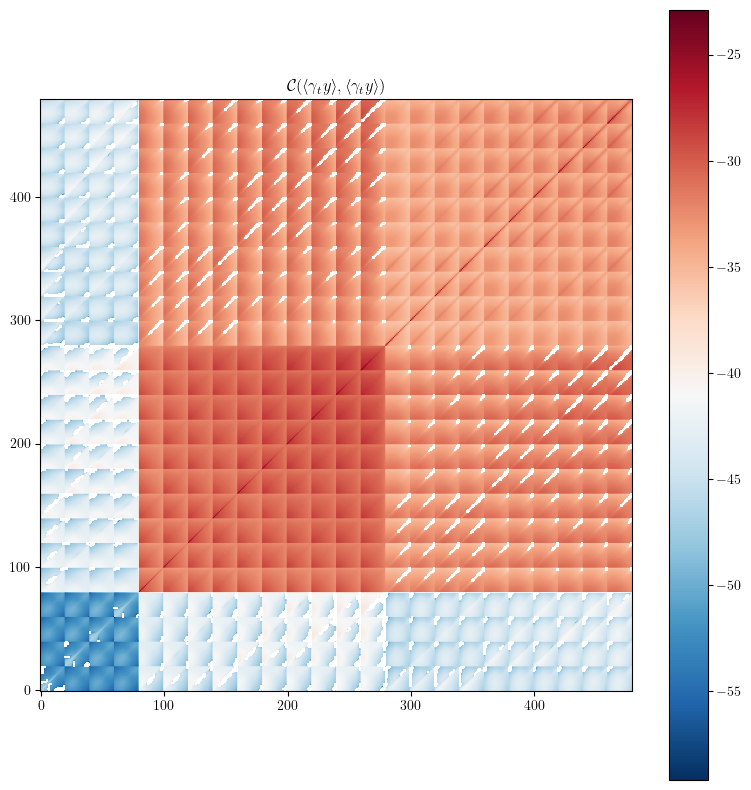

In [14]:
fig, ax = pl.subplots(1, 1, figsize=(8, 8))

corr = ax.imshow((np.log((cov_total))), origin='lower', cmap='RdBu_r')
fig.colorbar(corr, ax=ax)
fig.tight_layout()
ax.set_title(r'$\mathcal{C}(\langle \gamma_t y \rangle, \langle \gamma_t y \rangle)$')



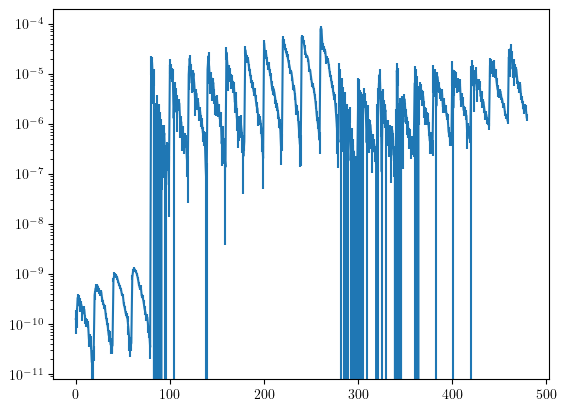

In [16]:
pl.figure()
pl.errorbar(np.arange(480), xi_all, yerr = np.sqrt(np.diag(cov_total)))
pl.yscale('log')

